In [1]:
%pip install seaborn
%pip install ipympl

In [2]:
%matplotlib widget

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import PIL

In [4]:
sns.set()

# Step 1: Calibrate the image

Pick the pixel positions between identical gold diffraction
spots on opposite sides of the origin of the digital diffractogram. This defines the center and scale of the diffractogram.

Hover the mouse over the image that is plotted with the cell below. It should show the position in pixel coordinates and the RGB value under the cursor.

The cell below should look like this:

```python
spot_pair = np.array([
    (y1, x1),
    (y2, x2)
]
```

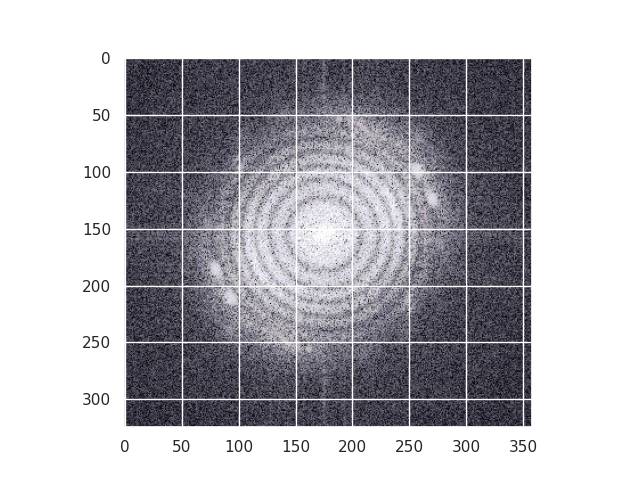

In [5]:
with PIL.Image.open('data/rings.jpg') as im:
    fig, axes = plt.subplots()
    axes.imshow(np.asarray(im))

In [6]:
spot_pair = np.array([
    (98, 256), # y1, x1
    (210, 92),  # y2, x2
])

## Validation

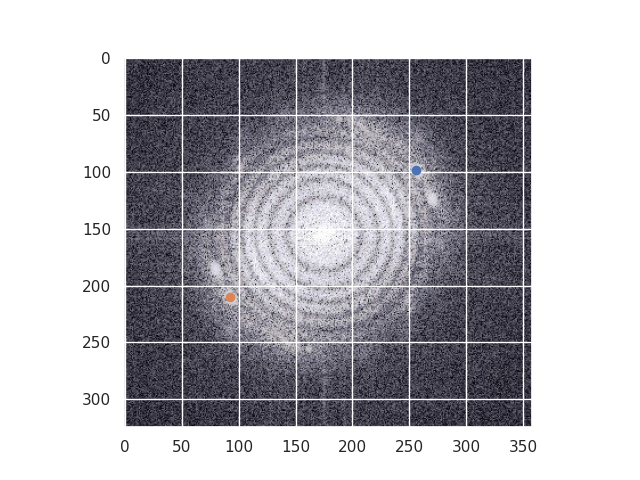

In [7]:
with PIL.Image.open('data/rings.jpg') as im:
    fig, axes = plt.subplots()
    axes.imshow(np.asarray(im))
    for (y, x) in spot_pair:
        axes.scatter(x, y)

## Calculate spot distance, radius and center

In [8]:
distance = np.linalg.norm(spot_pair[1] - spot_pair[0])
radius = distance / 2
center = np.mean(spot_pair, axis=0)
distance, radius, center

(198.59506539690256, 99.29753269845128, array([154., 174.]))

# Step 2: enter your measured points

Enter successive rows of `n` and (y, x) pixel coordinates on the ring-shaped minima and maxima corresponding to `n`. Even values for `n` are minima and odd values maxima of the ring pattern. You can enter several rows with pixel coordinates for the same `n` to improve the accuracy.

By making use of prior knowledge that the image was recorded underfocus, successive rings correspond to values of `n` of -2, -4, -6, etc.

The cell below should look like this:

```python
measured_points = [
    (n1, (y1, x1)),
    (n2, (y2, x2)),
    (n3, (y3, x3)),
    (n4, (y4, x4)),
    # etc.
]
```

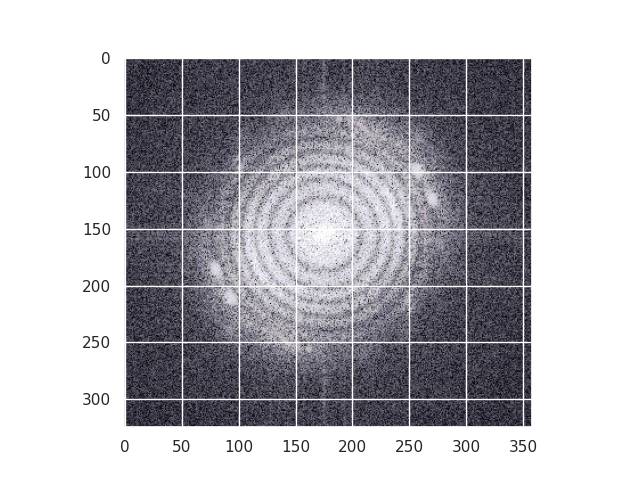

In [9]:
with PIL.Image.open('data/rings.jpg') as im:
    fig, axes = plt.subplots()
    axes.imshow(np.asarray(im))

In [10]:
measured_points = [
    # insert your measurements here:
    # (2, (157, 208)),
    # (2, (163, 142)),
    # (3, (137, 211)),
    # ...
    
    (-2, (157, 208)),
    (-2, (163, 142)),
    (-3, (137, 211)),
    (-10, (107, 244)),
]

At least two points with different `n` are required for fitting!

In [11]:
if len(measured_points) < 2:
    raise RuntimeError("Please update `measured_points` above! There have to be at least two (n, u) rows!")

# Step 3: Check the measured points

Confirm that all coordinates are entered correctly. Red points should be placed on maxima and blue points on minima

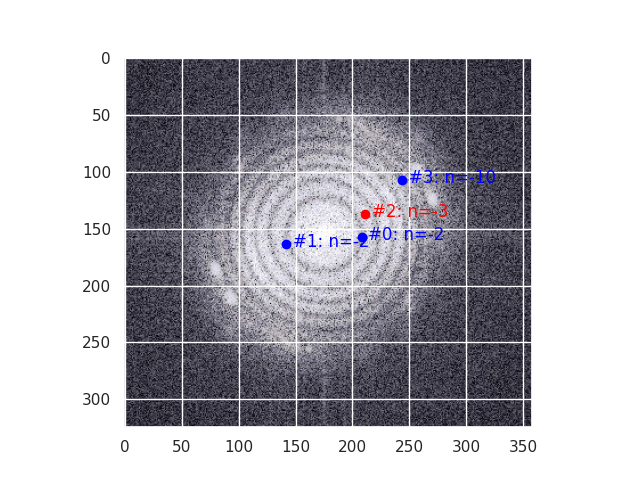

In [12]:
def is_odd(x):
    # bitwise and
    return x & 1

with PIL.Image.open('data/rings.jpg') as im:
    fig, axes = plt.subplots()
    axes.imshow(np.asarray(im))
    for i, (n, (y, x)) in enumerate(measured_points):
        color = 'red' if is_odd(n) else 'blue'
        axes.scatter(x, y, c=color)
        axes.annotate(f'#{i}: n={n}', (x + 6, y + 3), c=color)

# Step 4: Convert pixel coordinates to physical coordinates

Use the calibration and the known value for gold to convert the position of the rings to distance from the center in nm$^{-1}$

In [13]:
ring_distances = [(n, np.linalg.norm((y, x) - center)) for (n, (y, x)) in measured_points]

In [14]:
gold_spacing = 1/0.235  # unit: nm^-1

In [15]:
ring_spacing = [(n, u_pixel / radius * gold_spacing) for (n, u_pixel) in ring_distances]

# Step 5: calculate u^2 and n/u^2

In [16]:
calculated = [
    (n, u, u**2, n/(u**2))
    for (n, u) in ring_spacing
]

In [17]:
df = pd.DataFrame(calculated, columns=["n", "u", "u^2", "n/u^2"])
df

,n,u,u^2,n/u^2
0,-2,1.462705,2.139505,-0.934796
1,-2,1.424541,2.029316,-0.985554
2,-3,1.744962,3.044892,-0.985257
3,-10,3.613249,13.055571,-0.765957


# Step 6: Linear fit and plot

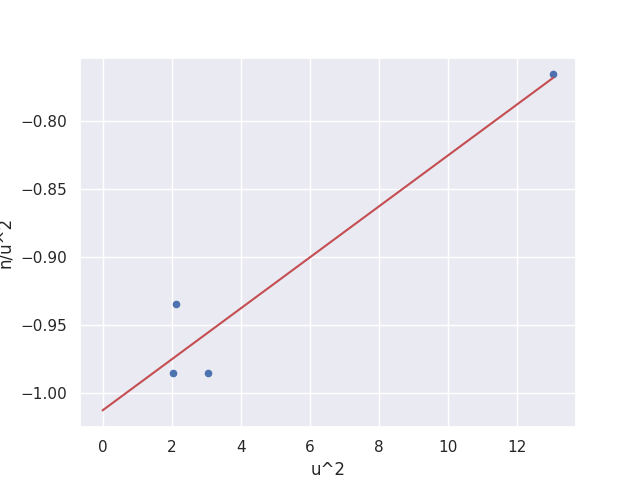

In [18]:
lin = LinearRegression()
lin.fit(df[['u^2']].values, df['n/u^2'].values)

ax = df.plot.scatter(x='u^2', y='n/u^2')
# Evaluate the fit at the intercept and at the maximum for plotting the fit line
x_points = np.array([0, np.max(df['u^2'])])
ax.plot(x_points, lin.predict(x_points[:, np.newaxis]), c='r')

# Step 6: Extract slope and intercept from the fit

In [19]:
lin.intercept_

-1.0127869302901127

In [20]:
lin.coef_

array([0.0187271])

# Step 7: Determine $\Delta f$ and Cs

In [21]:
lamb = 0.00251  # unit: nm

In [22]:
Df = lin.intercept_ / 2 /lamb
Df

-201.75038451994277

In [23]:
Cs = lin.coef_[0] / lamb**3
Cs

1184266.5776115996